In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import warnings
import sqlite3
from sqlalchemy import create_engine

# custom functions
from helper_functions import check_table_exists, create_connection
from helper_functions import plot_conf_matrix
from model_train_evaluate import train_model, evaluate_model

from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, roc_auc_score

import mlflow 
import mlflow.sklearn

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
db_file = 'data/train.db'

# getting the connection
conn = create_connection(db_file)

# checking tables in database
check_table_exists(conn)

# closing the connection
conn.close()

Tables in the DB:
data


***Reading the Data from DB***

In [3]:
# reading the data
if os.path.isfile(db_file):
    conn = create_connection(db_file)
    
    if conn is not None:
        # selecting random records
        data = pd.read_sql_query("SELECT *FROM data ORDER BY RANDOM() LIMIT 100001;", conn)
        conn.commit() # commiting the change
        conn.close() # closing the connection

In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,index,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y_y,87_y_y,88_y_y,89_y_y,90_y_y,91_y_y,92_y_y,93_y_y,94_y_y,95_y_y
0,521916,341915,0,0.428565,0.428565,0.285710,0.285710,0.714276,0.714276,1.0,...,-2.777638,7.548447,-2.188004,-0.445535,-14.497085,9.488895,-1.895818,13.178097,18.536980,-17.954488
1,43624,43623,0,0.599988,0.499992,0.000000,0.000000,0.599988,0.499992,0.0,...,-18.747462,-13.296392,3.561642,13.820512,-28.127375,-7.290573,7.580775,-8.787206,-13.999992,0.706706
2,366389,186388,0,0.333322,0.249994,1.999933,1.499963,2.333256,1.749956,0.0,...,0.929234,-10.354609,21.631635,-10.956507,-8.395287,12.498781,-0.680842,9.963056,14.397926,-3.247983
3,427923,247922,0,0.666644,0.666644,0.999967,0.999967,1.666611,1.666611,0.0,...,4.305560,-18.694009,16.570347,0.782899,-2.536946,15.027415,18.971905,6.783551,12.602017,-7.123621
4,486894,306893,0,0.333322,0.249994,0.333322,0.249994,0.666644,0.499988,0.0,...,4.112056,-28.006738,-2.954413,5.531563,11.234700,3.782200,-19.386668,5.713045,13.466615,-0.806065


In [6]:
# shape of the data
data.shape

(100001, 413)

In [7]:
y_true = data['is_duplicate']
data.drop(['id','index','is_duplicate'], axis=1, inplace=True)

***Converting Strings to Numeric values***

In [8]:
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_common
word_total
word_share
freq1+2
freq1-2
0_x_x
1_x_x
2_x_x
3_x_x
4_x_x
5_x_x
6_x_x
7_x_x
8_x_x
9_x_x
10_x_x
11_x_x
12_x_x
13_x_x
14_x_x
15_x_x
16_x_x
17_x_x
18_x_x
19_x_x
20_x_x
21_x_x
22_x_x
23_x_x
24_x_x
25_x_x
26_x_x
27_x_x
28_x_x
29_x_x
30_x_x
31_x_x
32_x_x
33_x_x
34_x_x
35_x_x
36_x_x
37_x_x
38_x_x
39_x_x
40_x_x
41_x_x
42_x_x
43_x_x
44_x_x
45_x_x
46_x_x
47_x_x
48_x_x
49_x_x
50_x_x
51_x_x
52_x_x
53_x_x
54_x_x
55_x_x
56_x_x
57_x_x
58_x_x
59_x_x
60_x_x
61_x_x
62_x_x
63_x_x
64_x_x
65_x_x
66_x_x
67_x_x
68_x_x
69_x_x
70_x_x
71_x_x
72_x_x
73_x_x
74_x_x
75_x_x
76_x_x
77_x_x
78_x_x
79_x_x
80_x_x
81_x_x
82_x_x
83_x_x
84_x_x
85_x_x
86_x_x
87_x_x
88_x_x
89_x_x
90_x_x
91_x_x
92_x_x
93_x_x
94_x_x
95_x_x
0_y_x
1_y_x
2_y_x
3_y_x
4_y_x
5_y_x
6_y_x
7_y_x
8_y_x

In [9]:
# mapping true labels to int
y_true = list(map(int, y_true.values))

***Random Train-Test Split***

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [11]:
print(f"Shape of Training Data: {X_train.shape}, ({len(y_train)})")
print(f"Shape of Test Data: {X_test.shape}, ({len(y_test)})")

Shape of Training Data: (70000, 410), (70000)
Shape of Test Data: (30001, 410), (30001)


In [12]:
# Distribution of output variable(y_true) in train and test data

train_dist = Counter(y_train)
train_len = len(y_train)
test_dist = Counter(y_test)
test_len = len(y_test)

print("Distribution in Train Data:")
print(f"Class 0: {int(train_dist[0])/train_len} \nClass 1: {int(train_dist[1])/train_len}")
print("-" * 50)
print("Distribution in Test Data:")
print(f"Class 0: {int(test_dist[0])/test_len} \nClass 1: {int(test_dist[1])/test_len}")

Distribution in Train Data:
Class 0: 0.6301142857142857 
Class 1: 0.36988571428571426
--------------------------------------------------
Distribution in Test Data:
Class 0: 0.6301123295890138 
Class 1: 0.3698876704109863


- As we see that the distribution of Y label is same in both Train and Test datasets.

### Baseline Model - Random Model

In [23]:
predicted_baseline = np.zeros((len(y_test), 2))

In [34]:
# getting random predictions:
for i in range(len(y_test)):
    random_probs = np.random.rand(1, 2)
    predicted_baseline[i] = ((random_probs/sum(sum(random_probs)))[0])  # normalizing so that sum of both probs is 1.

In [37]:
# getting the log loss
log_loss_baseline = log_loss(y_test, predicted_baseline)
print(f"Log Loss of the Random Model: {log_loss_baseline}")

Log Loss of the Random Model: 0.891008740800998


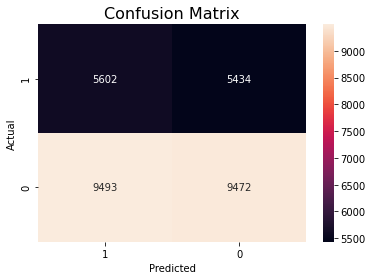

In [41]:
# plotting the confusion matrix
baseline_pred_labels = np.argmax(predicted_baseline, axis=1)
plot_conf_matrix(y_test, baseline_pred_labels)

In [45]:
print(classification_report(y_test, baseline_pred_labels))

              precision    recall  f1-score   support

           0       0.64      0.50      0.56     18965
           1       0.37      0.51      0.43     11036

    accuracy                           0.50     30001
   macro avg       0.50      0.50      0.49     30001
weighted avg       0.54      0.50      0.51     30001



### Logistic Regression

***Logistic Regression with Default Hyperparameters***

INFO: 'logistic_regression_default' does not exist. Creating a new experiment
Training accuracy: 76.21%
Validation Accuracy: 0.76190793640212
AUC Score: 0.7236184466205894
Precision: 0.7191757684945389
Recall: 0.5787422979340341
F1 Score: 0.6413616508510318


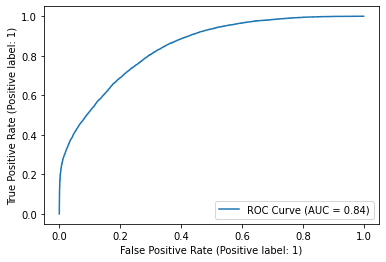

Model Run: a30da6a54e5d46d9910ab407453bbbef


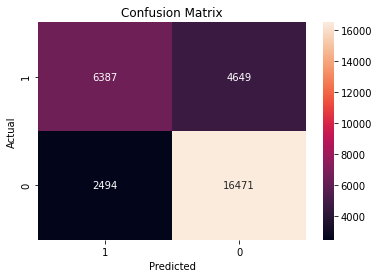

In [55]:
# Creating LogisticRegression model with Default Hyperparameters
logreg_model_def = LogisticRegression(random_state=42)

mlflow.set_experiment('logistic_regression_default')
with mlflow.start_run():
    # training the model
    train_model(logreg_model_def, X_train, y_train)
    # evaluating the model
    evaluate_model(logreg_model_def, X_test, y_test)
    # logging the model
    mlflow.sklearn.log_model(logreg_model_def, 'logistic_regression_default_model')
    
    # printing the model info
    print(f"Model Run: {mlflow.active_run().info.run_uuid}")
    
mlflow.end_run()

```
Model Info: 'runs:/a30da6a54e5d46d9910ab407453bbbef/logistic_regression_default_model'
```

***Hyperparameter Tuning***

- Using `hyperopt` for tuning.

In [16]:
# setting the space
space = {
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elastic']),
    'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'C': hp.choice('C', [0.001, 0.01, 0.1, 1, 10, 100, 1000]),
    'fit_intercept': hp.choice('fit_intercept', [True, False])
}
space

{'penalty': <hyperopt.pyll.base.Apply at 0x2080b988100>,
 'solver': <hyperopt.pyll.base.Apply at 0x2080b984f40>,
 'C': <hyperopt.pyll.base.Apply at 0x2080b984c40>,
 'fit_intercept': <hyperopt.pyll.base.Apply at 0x2080b984940>}

In [17]:
# objective function
def objective(space):
    logreg = LogisticRegression(penalty=space['penalty'],
                               solver=space['solver'],
                               C=space['C'],
                               fit_intercept=space['fit_intercept'])
    
    accuracy = cross_val_score(logreg, X_train, y_train, cv=5).mean()
    
    return {'loss': -accuracy, 'status': STATUS_OK} # negative accuracy as objective function minimizes loss.

In [18]:
# running the hyperopt function
trials = Trials()
best = fmin(fn=objective, 
           space=space, 
           algo=tpe.suggest,
           max_evals=80,
           trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [4:26:12<00:00, 199.65s/trial, best loss: -0.7962142857142858]


In [19]:
best

{'C': 1, 'fit_intercept': 0, 'penalty': 1, 'solver': 0}

In [20]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fit_intercept = [True, False]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elastic']

In [23]:
# best hyperparameters:
best_C = C[best['C']]
fit_int = fit_intercept[best['fit_intercept']]
best_solver = solver[best['solver']]
best_penalty = penalty[best['penalty']]

In [24]:
best_C, fit_int, best_solver, best_penalty

(0.01, True, 'newton-cg', 'l2')

In [25]:
# building Logistic Regression with tuned hyperparameters
logreg_tuned = LogisticRegression(penalty=best_penalty, C=best_C,
                                 fit_intercept=fit_int, solver=best_solver)

In [26]:
logreg_tuned

LogisticRegression(C=0.01, solver='newton-cg')

Training accuracy: 79.87%
Validation Accuracy: 0.7945401819939335
AUC Score: 0.7648338309357943
Precision: 0.7566943190171165
Recall: 0.6519496969148647
F1 Score: 0.7004276827371695


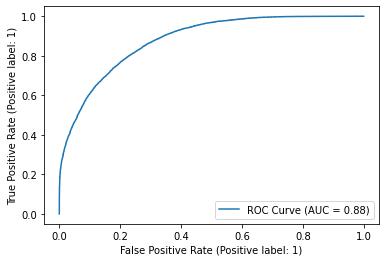

Model Run: 3a79b64f8b3f4dc3a95d9e39f82db427


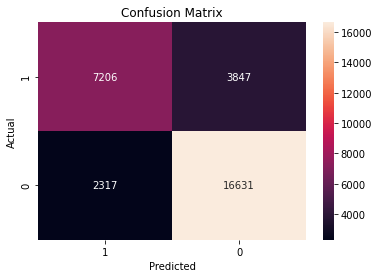

In [28]:
# setting up the mlflow experiment
mlflow.set_experiment('logistic_regression_tuned')

with mlflow.start_run():
    train_model(logreg_tuned, X_train, y_train)
    evaluate_model(logreg_tuned, X_test, y_test)
    
    # logging the model
    mlflow.sklearn.log_model(logreg_tuned, "logistic_regression_tuned_model")
    print(f"Model Run: {mlflow.active_run().info.run_uuid}")

mlflow.end_run()

- The ***Tuned Logistic Regression Model*** performs better than the ***Default Logistic Regression Model***
- Validation Accuracy: 79.45% (default: 76.1%)
- F1 Score: .700 (Default: 0.6413)

### SVM Classifier

***SVC with Default Hyperparameters***

INFO: 'svm_default' does not exist. Creating a new experiment
Training accuracy: 78.00%
Validation Accuracy: 0.7726742441918603
AUC Score: 0.7409074459422781
Precision: 0.7233301677746122
Recall: 0.620193612593866
F1 Score: 0.6678032148075987


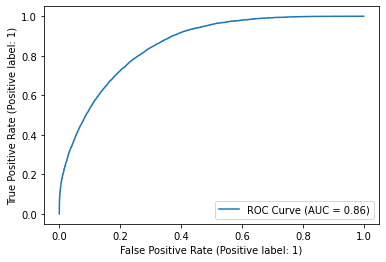

Model Run: 4975e78d50d64ff08f3414e62ccb2cba


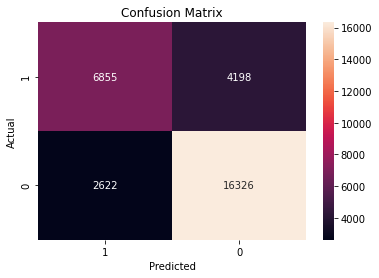

In [31]:
svm_def = SVC(random_state=42)

mlflow.set_experiment("svm_default")
with mlflow.start_run():
    train_model(svm_def, X_train, y_train)
    evaluate_model(svm_def, X_test, y_test)
    
    # logging the model
    mlflow.sklearn.log_model(svm_def, "svm_default_model")
    print(f"Model Run: {mlflow.active_run().info.run_uuid}")

mlflow.end_run()

### XGBoost Classifier

***XGBoost with default hyperparameters***

INFO: 'xgb_default' does not exist. Creating a new experiment
[08:42:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 93.22%
Validation Accuracy: 0.8300389987000434
AUC Score: 0.8119110012461288
Precision: 0.7841657912329291
Recall: 0.7430769230769231
F1 Score: 0.7630686306398401


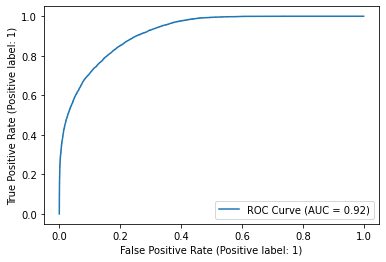

Model Run: c4d30576d95340d7b842bac5647876c9


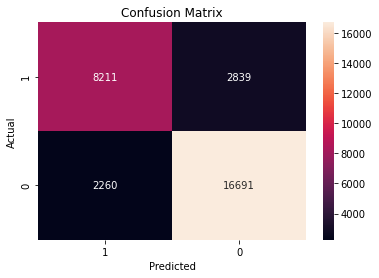

In [24]:
# setting up the mlflow experiment
xgb_model_def = xgb.XGBClassifier()

mlflow.set_experiment("xgb_default")
with mlflow.start_run():
    # training the model
    train_model(xgb_model_def, X_train, y_train)
    # evaluate the model
    evaluate_model(xgb_model_def, X_test, y_test)
    
    # logging the model
    mlflow.sklearn.log_model(xgb_model_def, "xgboost_default_model")
    print(f"Model Run: {mlflow.active_run().info.run_uuid}")
    
mlflow.end_run()

*XGBoost with default hyperparameters is overfitting.*

***XGBoost Hyperparameter Tuning***

In [65]:
# space
space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 100, dtype=int)),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}

In [66]:
# setting up the objective function
def objective(space):
    xgb_model_tuned = xgb.XGBClassifier(n_estimators=space['n_estimators'],
                                       learning_rate=space['learning_rate'],
                                       max_depth=space['max_depth'],
                                       min_child_weight=space['min_child_weight'],
                                       gamma=space['gamma'],
                                       subsample=space['subsample'],
                                       colsample_bytree=space['colsample_bytree'],
                                       objective=space['objective'],
                                       booster=space['booster'],
                                       tree_method=space['tree_method'],)
    
    xgb_model_tuned.fit(X_train, y_train)
    predictions = xgb_model_tuned.predict(X_test)
    score = roc_auc_score(y_test, predictions)
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

In [67]:
# getting the parameters
trials = Trials()
best = fmin(fn=objective,
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

[11:05:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:08:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:10:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [68]:
# having a look at the best hyperparameters
best

{'colsample_bytree': 0.8500000000000001,
 'gamma': 0.6000000000000001,
 'learning_rate': 0.07500000000000001,
 'max_depth': 9,
 'min_child_weight': 6.0,
 'n_estimators': 7,
 'subsample': 0.8}

In [69]:
# creating the model
xgb_tuned = xgb.XGBClassifier(n_estimators=7,
                             gamma=0.60001,
                             learning_rate=0.075,
                             max_depth=9,
                             min_child_weight=6.0,
                             colsample_bytree=0.85,
                             subsample=0.8)

INFO: 'xgb_tuned' does not exist. Creating a new experiment
[09:45:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 83.99%
Validation Accuracy: 0.8179394020199326
AUC Score: 0.7891847395915784
Precision: 0.7959745762711864
Recall: 0.68
F1 Score: 0.7334309419228892


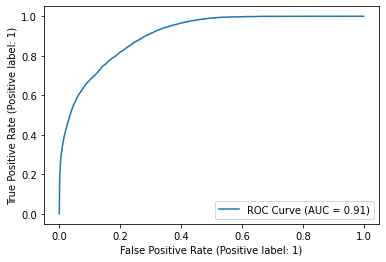

Model run: 670fe88119204b58a52d1a17b1d75cfe


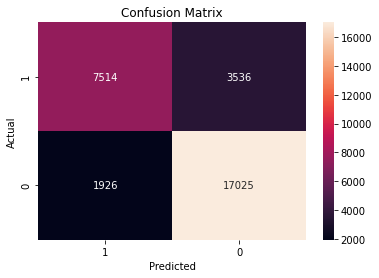

In [70]:
# setting the MLFlow experiment 
mlflow.set_experiment('xgb_tuned')
with mlflow.start_run():
    train_model(xgb_tuned, X_train, y_train)
    evaluate_model(xgb_tuned, X_test, y_test)
    
    # logging the model
    mlflow.sklearn.log_model(xgb_tuned, 'xgboost_tuned_model')
    print(f"Model run: {mlflow.active_run().info.run_uuid}")
    
mlflow.end_run()

### RandomForest Classifier 

***RandomForest Classifier with default Hyperparameters***

INFO: 'random_forest' does not exist. Creating a new experiment
Training accuracy: 100.00%
Validation Accuracy: 0.8189727009099697
AUC Score: 0.7897186425278936
Precision: 0.802477044629511
Recall: 0.6773001712174461
F1 Score: 0.7345941455309583


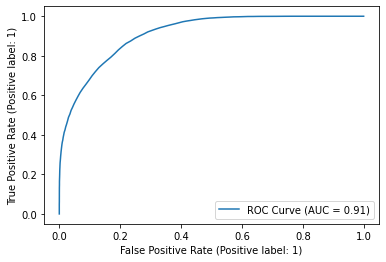

Model run: 23a5792b21ea44d6ad35a09107637a3e


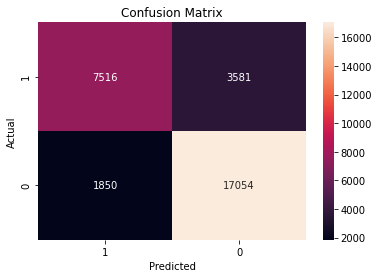

In [14]:
# setting up the experiment 
rf_clf = RandomForestClassifier()

mlflow.set_experiment("random_forest")
with mlflow.start_run():
    # training the model
    train_model(rf_clf, X_train, y_train)
    # evaluate the model
    evaluate_model(rf_clf, X_test, y_test)
    
    # logging the model
    mlflow.sklearn.log_model(rf_clf, 'random_forest_default')
    print(f"Model run: {mlflow.active_run().info.run_uuid}")

***RandomForest Classifier with Hyperparameter Tuning***

In [15]:
# defining the space 
space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 10, 1200, 10),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
    'min_samples_split': hp.uniform('min_samples_split', 0, 1),
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 600, 900, 1200, 1500])
}

In [18]:
# objective function
def objective(space):
    model = RandomForestClassifier(criterion=space['criterion'],
                                  max_depth=space['max_depth'],
                                  max_features=space['max_features'],
                                  min_samples_leaf=space['min_samples_leaf'],
                                  min_samples_split=space['min_samples_split'],
                                  n_estimators=space['n_estimators'])
    
    accuracy = cross_val_score(model, X_train, y_train, cv=5).mean()
    return {'loss': -accuracy, 'status': STATUS_OK}

In [19]:
# finding best hyperparameters
trials = Trials()
best = fmin(fn=objective, 
           space=space, 
           algo=tpe.suggest,
           max_evals=50,
           trials=trials)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:44:09<00:00, 844.98s/trial, best loss: -0.7852571428571429]


In [20]:
best

{'criterion': 0,
 'max_depth': 700.0,
 'max_features': 1,
 'min_samples_leaf': 0.005656322054586932,
 'min_samples_split': 0.014859475974495509,
 'n_estimators': 6}

In [23]:
# creating the model
rf_clf_tuned = RandomForestClassifier(n_estimators=6,
                                     criterion='gini',
                                     max_depth=700,
                                     max_features='sqrt',
                                     min_samples_leaf=0.00565632,
                                     min_samples_split=0.01485,)

Training accuracy: 77.27%
Validation Accuracy: 0.7677410752974901
AUC Score: 0.7315001131102179
Precision: 0.7290072102052135
Recall: 0.5922321348112103
F1 Score: 0.6535401750198887


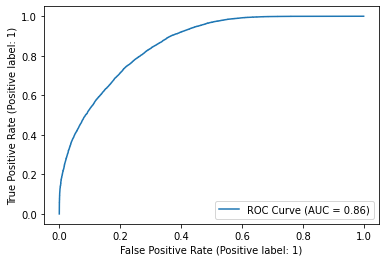

Model Run: 7456ad1195ba45209ca77b999ccf2308


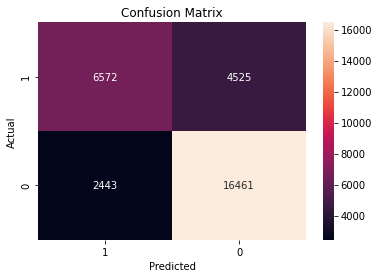

In [24]:
# training the model
mlflow.set_experiment('random_forest')
with mlflow.start_run():
    train_model(rf_clf_tuned, X_train, y_train)
    evaluate_model(rf_clf_tuned, X_test, y_test)
    
    mlflow.sklearn.log_model(rf_clf_tuned, 'random_forest_tuned')
    print(f"Model Run: {mlflow.active_run().info.run_uuid}")